# Analyzing the Vibrations of a Guitar String

## Motivation

### Analyzing the vibration of guitar strings has important applications in simulating instruments for use in music composition. If guitar strings can be correctly modeled, then more lifelike digital instruments can be created. 

### Additionaly, it will open doors towards more novel design of physical guitars, as luthiers (builders of guitars and other instruments) will be able to prototype new and interesting designs digitally, without using physical resources.

### In this project, I aim to simulate the vibrations of the open strings of the guitar - specifically, an electric guitar with a 25.5" scale length and steel strings. Specifically, I aim to recreate the vibrations of the string in "open position" - that is, without any fretted notes - while plucking the string lightly on the lower end of the string, over the pickups in what is known as the "active length" of the string.

# Initialize constants

### Here, I initialize constants such as the known frequencies of the open guitar strings, the scale length, the center of the active length, and c, or the wave speed.

### Notice that I re-initialize the scale length and center of the active length to have values in centimeters. This is to prevent overflow errors in the Verlet method, which I use later to calculate the differential wave equation.

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# These measurements are for 10-46 guage steel guitar strings tuned on E-standard for a 25 1/2" scale length guitar from strings 1-6 (E, A, D, G, B, E)
# For example, D'Addario Regular Light Electric Guitar Strings EXL110 (https://www.daddario.com/products/guitar/electric-guitar/xl-nickel/exl110-nickel-wound-regular-light-10-46/)
KNOWN_FREQS = np.array([82.41, 110.00, 146.83, 196.00, 246.94, 329.63], np.longdouble) # String frequencies, Hz
SCALE_LENGTH = 25.5 * 0.0254 # Scale length, m
ACTIVE_CENTER = 0.556825 # Active center, m
c = 2 * SCALE_LENGTH * KNOWN_FREQS # Wave speed, m/s

# We recalculate these parameters to make scaling the x-axis more sensible
SCALE_LENGTH = 25.5 * 2.54 # Scale length, cm
ACTIVE_CENTER = 55.6825 # Active center, cm

# Solve the wave equation

### Here, we initialize the displacement of the string to a triangular approximation, such that it is plucked realistically within the active zone. Most existing simulations of guitar strings I found assumed the string was plucked in the exact center, creating a sinusoidal standing wave with harmonic frequencies. I wanted to see how the simulation would differ if I plucked the string more realistically.

### Note, again, there is some units trickery here to prevent overflow errors. One of the most difficult parts of this project was tracking down the overflow error and figuring out what range the values of SCALE_LENGTH and c needed to be to prevent it.

<IPython.core.display.Javascript object>


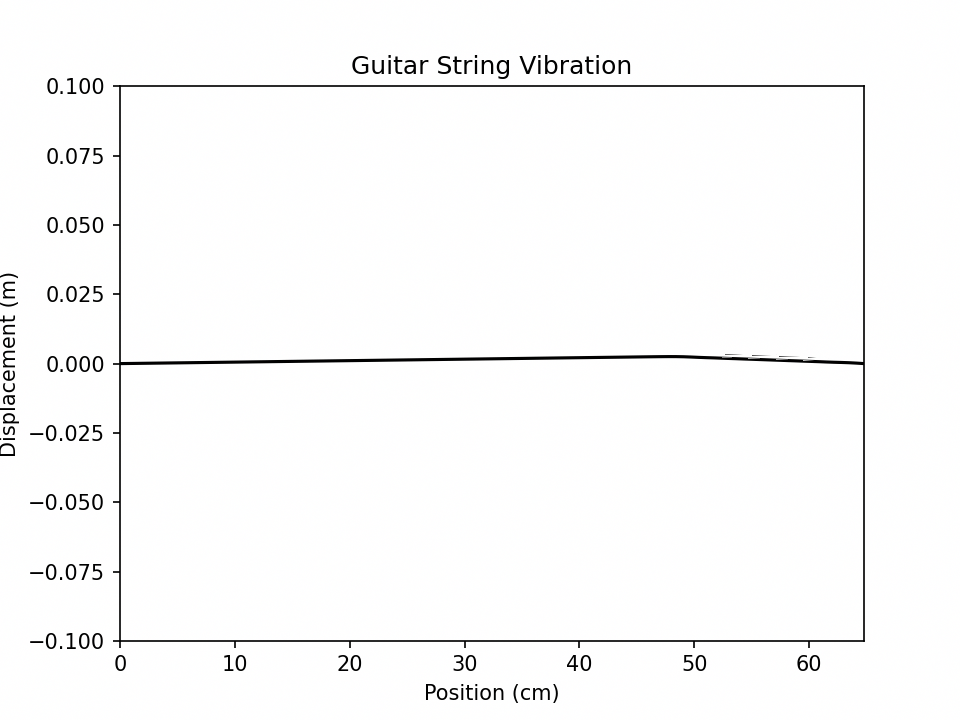

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import ImageMagickWriter  
# The animation lags pretty heavily on my laptop, but it saves locally correctly.
%matplotlib notebook 

# Length of the string
L = np.longdouble(SCALE_LENGTH)  

# Number of grid points
N = 100  

# Total time 
T = 50  
dt = np.longdouble(0.01)  # Time step (s)
dx = np.longdouble(L / N)  # Grid spacing (cm)
string = 5 # String choice (0 = low E, 5 = high E)

# The location of the pluck on the string - in the center of the "active length," where the guitarist usually plucks or strums
pluck = round(N * ACTIVE_CENTER / SCALE_LENGTH)

# The displacement, in meters, of the string when it is released from the pluck
h_pluck = 0.003

# Initial conditions
x = np.linspace(0, L, N)  # Grid points
u = np.zeros(N, np.longdouble)  # Initial displacement
u[pluck] = h_pluck # Add the pluck to the string

# Calculate the equation for the string from the pluck to the bridge (right end)
b = h_pluck + (h_pluck / (N - 1 - pluck)) * pluck

# Set the string to a triangle shape. This is a good approximation of the stretched string,
# since it's difficult to come up with the exact curve since the pluck isn't centered
for i in range(0, pluck):
    u[i] = h_pluck / pluck * i
    
for i in range(pluck + 1, N):
    u[i] = -h_pluck / (N - 1 - pluck) * i + b
    
v = np.zeros(N, np.longdouble)  # Initial velocity

# update the wave at each time step
def update_wave(frame):
    global u, v
    
    # This uses the Verlet method. The extra term of * 0.0001 is to rescale the answer properly,
    # since dx is in cm. This is necessary to prevent overflow errors - the numpy diffeq functions
    # also avoid overflows, but don't allow a frame-by-frame update for the animation.
    u[1:-1] += v[1:-1] * dt + 1 / dx ** 2 * 0.5 * c[string] ** 2 * (u[:-2] - 2 * u[1:-1] + u[2:]) * dt**2 * 0.0001
    
    # Same here as the above line.
    v[1:-1] += 0.5 * 1 / dx ** 2 * c[string] ** 2 * (u[:-2] - 2 * u[1:-1] + u[2:]) * dt * 0.0001
    line.set_ydata(u)
    return line,

# Create the animation plot. Using a slightly different method here to make animating easier.
fig, ax = plt.subplots()
ax.set_xlim(0, L)
ax.set_ylim(-0.1, 0.1)
ax.set_xlabel('Position (cm)')
ax.set_ylabel('Displacement (m)')
ax.set_title('Guitar String Vibration')

# Create initial plot.
line, = ax.plot(x, u, 'k-')

# Create animation. interval=5 so that motion is slower than realistic motion, to make visualizing the motion easier
anim = FuncAnimation(fig, update_wave, frames=int(T/dt), interval=5, blit=True)

# Save the animation
# anim.save('animation.mp4')

### Try running the simulation with the y-axis limits at +=0.0004 m, +-0.024 m, and +-0.1 m. (If the simulation lags, uncomment the anim.save line and view the resulting video locally.)

### The first simulation allows easy viewing of the wave behavior. Notice, however, that these proportions are very off, and guitar strings do not vibrate like this! The other two simulations zoom out in scale, and the final one shows a much more reasonable image.

# Applying a Fourier Transformation

### Here, we apply a Fourier transformation to the ending displacement values of the string. This gives us a breakdown of what frequencies are making up the vibrations.

<IPython.core.display.Javascript object>


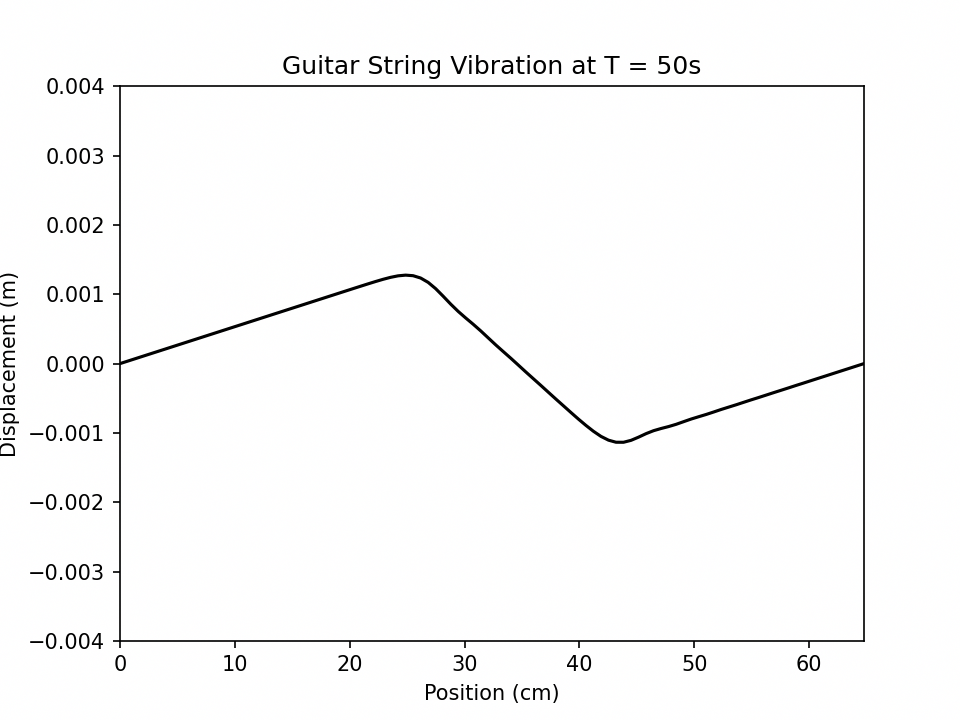

<IPython.core.display.Javascript object>


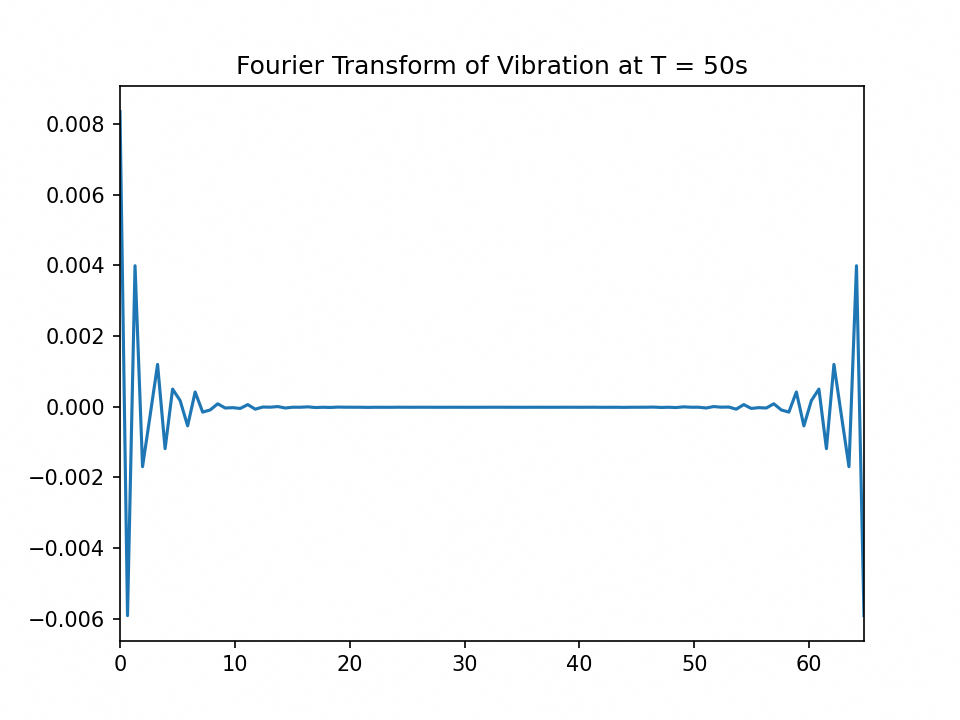

In [58]:
# Plot the vibration at the end of simulation time
plt.plot(x, u, "k-")
plt.xlim(0, L)
plt.ylim(-0.004, 0.004)
plt.xlabel("Position (cm)")
plt.ylabel("Displacement (m)")
plt.title("Guitar String Vibration at T = {}s".format(T))
plt.show()

# Fourier transform function
def discrete_fourier(y):
    N = len(y)
    # Calculate the Fourier coefficients
    c = np.zeros(N, complex)
    for k in range(N):
        for n in range(N):
            c[k] += y[n] * np.exp(-2j * np.pi * k * n / N)
    return c

# Transform the vibration at the end of simulation time
fourier = discrete_fourier(u)

# Plot the Fourier transformation
plt.figure()
plt.plot(x, fourier)
plt.xlim(0, L)
plt.title("Fourier Transform of Vibration at T = {}s".format(T))
plt.show()